#### Classification of wetland types

In [1]:
import ee
import os
import geemap
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
import numpy as np

from scipy.stats import entropy

In [2]:
ee.Initialize(project = "ee-ogalloethel")

In [3]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}\nPlease check your path!")
else:
    print(f"Base directory found: {base_dir}")


# Set AOI from shapefile
shapefile = gpd.read_file(os.path.join(base_dir, 'baringo_bbox/baringo_bbox.shp'))
study_area = ee.Geometry(shapefile.geometry[0].__geo_interface__)


Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


In [4]:
# Function to read a raster file and return an aligned array
def clip_to_aoi(image):
    """
    Clip an ee.Image to the study_area geometry.
    Args:
        image (ee.Image): The image to clip.
    Returns:   
        ee.Image: The clipped image.
        """
    if not isinstance(image, ee.Image):
        raise TypeError("Input must be an ee.Image")
    return image.clip(study_area)

# Function to export an ee.Image to Google Drive
def export_image_to_drive(image, year, label='image', folder='Exports', scale=30):
    """
    Export an ee.Image to Google Drive.
    Args:
        image (ee.Image): The image to export.
        year (int): The year associated with the image.
        label (str): A label for the exported image.
        folder (str): The folder in Google Drive to save the image.
        scale (int): The scale of the exported image in meters.
    Returns:
        None
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'{label}_{year}',
        folder=folder,
        fileNamePrefix=f'{label}_{year}',
        scale=scale,
        region=study_area,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Export started: {label}_{year}")



#### Multitemporal NDVI stats: minimum, maximum, standard deviation and spatal entropy

In [ ]:
def compute_monthly_ndvi(year=2024):
    """
    Compute NDVI statistics for each month of a given year.
    Returns:
        dict: Dictionary with month as key and NDVI stats as values.
    """
    results = {}
    for month in range(1, 13):
        start = datetime.date(year, month, 1)
        if month == 12:
            end = datetime.date(year + 1, 1, 1)
        else:
            end = datetime.date(year, month + 1, 1)
        s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
              .filterBounds(study_area)
              .filterDate(str(start), str(end))
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .map(clip_to_aoi)
              .map(lambda img: img.addBands(
                  img.normalizedDifference(['B8', 'B4']).rename('NDVI')))
              .select('NDVI'))
        ndvi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDVI_SD_{year}_{month:02d}')
        ndvi_min = s2.reduce(ee.Reducer.min()).rename(f'NDVI_Min_{year}_{month:02d}')
        ndvi_max = s2.reduce(ee.Reducer.max()).rename(f'NDVI_Max_{year}_{month:02d}')
        
        results[month] = (ndvi_std, ndvi_min, ndvi_max)
    return results

# Export NDVI statistics for each month
monthly_ndvi = compute_monthly_ndvi(2024)
for month, (ndvi_std, ndvi_min, ndvi_max) in monthly_ndvi.items():
    export_image_to_drive(ndvi_std, f'2024_{month:02d}', label='NDVI_SD', folder='NDVI')
    export_image_to_drive(ndvi_min, f'2024_{month:02d}', label='NDVI_Min', folder='NDVI')
    export_image_to_drive(ndvi_max, f'2024_{month:02d}', label='NDVI_Max', folder='NDVI')


In [ ]:
# Define function to compute monthly NDVI entropy using median NDVI
def compute_ndvi_entropy(year, month):
    # Define start and end date of the month
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    # Load Sentinel-2 collection, filter by AOI, date and cloudiness
    s2 = (
        ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterBounds(study_area)
        .filterDate(start, end)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
        .map(lambda img: img.addBands(img.normalizedDifference(['B8', 'B4']).rename('NDVI')))
    )

    # Compute median NDVI composite for the month (robust to outliers)
    median_ndvi = s2.select('NDVI').median()

    # Clip to AOI (optional, but keeps data small and clean)
    median_ndvi_clipped = median_ndvi.clip(study_area).rename(f'Median_NDVI_{year}{month:02d}')

    # Compute GLCM texture entropy
    # Step 1: Bin NDVI to discrete classes (e.g., -1 to +1 scaled to 0-20)
    # This is required for GLCM because it expects integer categorical data
    ndvi_binned = (
        median_ndvi_clipped
        .multiply(10)    # scale: NDVI [-1,1] -> [-10,10]
        .add(10)         # shift: [-10,10] -> [0,20]
        .toInt16()
        .rename('NDVI_bin')
    )

    # Step 2: Compute GLCM entropy in 3x3 window → measures local spatial heterogeneity
    glcm = ndvi_binned.glcmTexture(size=3)

    # Extract the entropy band
    ndvi_entropy = glcm.select('NDVI_bin_ent').rename(f'NDVI_Entropy_{year}{month:02d}')

    return ndvi_entropy

# Loop through all months of 2024, compute & export
for month in range(1, 13):
    entropy_img = compute_ndvi_entropy(2024, month)
    export_image_to_drive(image=entropy_img,year=2024,label=f'NDVI_Entropy_{month:02d}',folder='NDVI',scale=10)


#### Multitemporal NDWI stats: minimum, maximum, standard deviation and spatal entropy

In [ ]:
def compute_monthly_ndwi(year=2024):
    """
    Compute NDWI statistics for each month of a given year.
    Returns:
        dict: Dictionary with month as key and NDWI stats as values.
    """
    results = {}
    for month in range(1, 13):
        start = datetime.date(year, month, 1)
        if month == 12:
            end = datetime.date(year + 1, 1, 1)
        else:
            end = datetime.date(year, month + 1, 1)

        s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
              .filterBounds(study_area)
              .filterDate(str(start), str(end))
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .map(clip_to_aoi)
              .map(lambda img: img.addBands(
                  img.normalizedDifference(['B8', 'B3']).rename('NDWI').toFloat()))
              .select('NDWI'))

        ndwi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDWI_SD_{year}_{month:02d}')
        ndwi_min = s2.reduce(ee.Reducer.min()).rename(f'NDWI_Min_{year}_{month:02d}')
        ndwi_max = s2.reduce(ee.Reducer.max()).rename(f'NDWI_Max_{year}_{month:02d}')
        
        results[month] = (ndwi_std, ndwi_min, ndwi_max)
    return results

monthly_ndwi = compute_monthly_ndwi(2024)
for month, (ndwi_std, ndwi_min, ndwi_max) in monthly_ndwi.items():
    export_image_to_drive(ndwi_std, f'2024_{month:02d}', label='NDWI_SD', folder='NDWI')
    export_image_to_drive(ndwi_min, f'2024_{month:02d}', label='NDWI_Min', folder='NDWI')
    export_image_to_drive(ndwi_max, f'2024_{month:02d}', label='NDWI_Max', folder='NDWI')


In [ ]:
def compute_ndwi_entropy(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(start, end)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.normalizedDifference(['B3', 'B8']).rename('NDWI'))
           )

    median_ndwi = s2.select('NDWI').median()
    median_ndwi_clipped = clip_to_aoi(median_ndwi).rename(f'Median_NDWI_{year}{month:02d}')

    # Bin NDWI: shift + scale (NDWI ranges roughly -1 to 1)
    ndwi_binned = median_ndwi_clipped.multiply(10).add(10).toInt16().rename('NDWI_bin')

    # Compute GLCM texture entropy (window size 3)
    glcm = ndwi_binned.glcmTexture(size=3)
    ndwi_entropy = clip_to_aoi(glcm.select('NDWI_bin_ent')).rename(f'NDWI_Entropy_{year}{month:02d}')

    return ndwi_entropy

for month in range(1, 13):
    entropy_img = compute_ndwi_entropy(2024, month)
    export_image_to_drive(
        image=entropy_img,
        year=2024,
        label=f'NDWI_Entropy_{month:02d}',
        folder='NDWI',
        scale=10
    )


#### Multitemporal BSI stats: minimum, maximum, standard deviation and spatal entropy

In [ ]:
def compute_monthly_bsi(year=2024):
    """
    Compute BSI statistics for each month of a given year.
    Returns:
        dict: Dictionary with month as key and BSI stats as values.
    """
    results = {}
    for month in range(1, 13):
        start = datetime.date(year, month, 1)
        if month == 12:
            end = datetime.date(year + 1, 1, 1)
        else:
            end = datetime.date(year, month + 1, 1)

        s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
              .filterBounds(study_area)
              .filterDate(str(start), str(end))
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .map(clip_to_aoi)
              .map(lambda img: img.addBands(
                  img.expression(
                      '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
                      {
                          'SWIR': img.select('B11'),
                          'RED': img.select('B4'),
                          'NIR': img.select('B8'),
                          'BLUE': img.select('B2')
                      }).rename('BSI').toFloat()))
              .select('BSI'))

        bsi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'BSI_SD_{year}_{month:02d}')
        bsi_min = s2.reduce(ee.Reducer.min()).rename(f'BSI_Min_{year}_{month:02d}')
        bsi_max = s2.reduce(ee.Reducer.max()).rename(f'BSI_Max_{year}_{month:02d}')
        
        results[month] = (bsi_std, bsi_min, bsi_max)
    return results

# Compute and export
monthly_bsi = compute_monthly_bsi(2024)
for month, (bsi_std, bsi_min, bsi_max) in monthly_bsi.items():
    export_image_to_drive(bsi_std, f'2024_{month:02d}', label='BSI_SD', folder='BSI')
    export_image_to_drive(bsi_min, f'2024_{month:02d}', label='BSI_Min', folder='BSI')
    export_image_to_drive(bsi_max, f'2024_{month:02d}', label='BSI_Max', folder='BSI')


In [ ]:
def compute_bsi_entropy(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(start, end)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.expression(
                  '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
                  {
                      'SWIR': img.select('B11'),
                      'RED': img.select('B4'),
                      'NIR': img.select('B8'),
                      'BLUE': img.select('B2')
                  }
              ).rename('BSI')
          ))
          .select('BSI')
         )

    median_bsi = s2.median()
    median_bsi_clipped = clip_to_aoi(median_bsi).rename(f'Median_BSI_{year}{month:02d}')

    # Bin BSI: scale and shift to positive integers (BSI approx range -1 to 1)
    bsi_binned = median_bsi_clipped.multiply(10).add(10).toInt16().rename('BSI_bin')

    # Compute GLCM texture entropy with 3x3 window
    glcm = bsi_binned.glcmTexture(size=3)
    bsi_entropy = clip_to_aoi(glcm.select('BSI_bin_ent')).rename(f'BSI_Entropy_{year}{month:02d}')

    return bsi_entropy

for month in range(1, 13):
    entropy_img = compute_bsi_entropy(2024, month)
    export_image_to_drive(
        image=entropy_img,
        year=2024,
        label=f'BSI_Entropy_{month:02d}',
        folder='BSI',
        scale=10
    )


#### Temporal entropy per indice

In [ ]:
# Function to get median NDVI per month 
def mask_clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)

def get_monthly_ndvi_stack(year):
    monthly_images = []
    for month in range(1, 13):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                      .filterBounds(study_area)
                      .filterDate(start, end)
                      .map(clip_to_aoi)
                      .map(mask_clouds)
                      .map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI'))
                     )

        size = collection.size().getInfo()  # get collection size
        if size == 0:
            print(f"No images for {year}-{month}, adding empty image.")
            # create an empty image with NDVI band filled with NaN or zero
            empty_img = ee.Image(ee.Array([float('nan')])).rename('NDVI').clip(study_area)
            monthly_images.append(empty_img.set('month', month))
        else:
            median_ndvi = collection.median().select('NDVI').rename(f'NDVI_{month}')
            monthly_images.append(median_ndvi)

    monthly_stack = ee.Image.cat(monthly_images).clip(study_area)
    return monthly_stack


# Get the monthly NDVI stack for the specified year
year = 2024
monthly_ndvi_stack = get_monthly_ndvi_stack(year)
export_image_to_drive(monthly_ndvi_stack, year, label='Monthly_NDVI_Stack', folder='NDVI', scale=10)


In [ ]:
# Path to your downloaded multi-band NDVI GeoTIFF
ndvi_tif_path = r'C:\Users\Ethel Ogallo\Downloads\NDVI stats\Monthly_NDVI_Stack_2024.tif'
output_entropy_path = r'C:\Users\Ethel Ogallo\Downloads\NDVI stats\temporal_entropy_ndvi_2024.tif'

# Open the multiband NDVI raster
with rasterio.open(ndvi_tif_path) as src:
    ndvi_stack = src.read()  # shape: (bands=12, height, width)
    profile = src.profile

print(f'NDVI stack shape (bands, rows, cols): {ndvi_stack.shape}')

# Reshape to (rows*cols, 12) for pixel-wise processing
bands, rows, cols = ndvi_stack.shape
ndvi_reshaped = ndvi_stack.reshape(bands, -1).T  # shape: (pixels, bands)

# Replace nan or no-data with some value, or mask later
# Here, we mask pixels where all months are nan or zeros (assuming zeros mean no data)
valid_mask = ~np.all(np.isnan(ndvi_reshaped), axis=1)

# Initialize entropy array
temporal_entropy = np.full(ndvi_reshaped.shape[0], np.nan)

# Define bins for NDVI (to create histogram for entropy calculation)
bins = np.linspace(-1, 1, 21)  # 20 bins between -1 and 1

def compute_entropy(pixel_timeseries):
    # Remove nan values
    pixel_timeseries = pixel_timeseries[~np.isnan(pixel_timeseries)]
    if len(pixel_timeseries) == 0:
        return np.nan
    
    # Histogram counts
    hist, _ = np.histogram(pixel_timeseries, bins=bins, density=True)
    hist = hist + 1e-10  # avoid zeros for log
    
    return entropy(hist, base=2)

# Compute entropy only for valid pixels
for i in np.where(valid_mask)[0]:
    temporal_entropy[i] = compute_entropy(ndvi_reshaped[i])

# Reshape entropy back to (rows, cols)
entropy_map = temporal_entropy.reshape(rows, cols)

# Save the entropy map as GeoTIFF
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    nodata=np.nan
)

with rasterio.open(output_entropy_path, 'w', **profile) as dst:
    dst.write(entropy_map.astype(rasterio.float32), 1)

print(f"Temporal entropy saved to {output_entropy_path}")


In [ ]:
# Function to get median NDWI per month 
def get_monthly_ndwi_stack(year):
    monthly_images = []
    for month in range(1, 13):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                      .filterBounds(study_area)
                      .filterDate(start, end)
                      .map(clip_to_aoi)
                      .map(mask_clouds)
                      .map(lambda img: img.normalizedDifference(['B3', 'B8']).rename('NDWI'))
                     )

        size = collection.size().getInfo()  # get collection size
        if size == 0:
            print(f"No images for {year}-{month}, adding empty image.")
            # create an empty image with NDWI band filled with NaN or zero
            empty_img = ee.Image(ee.Array([float('nan')])).rename('NDWI').clip(study_area)
            monthly_images.append(empty_img.set('month', month))
        else:
            median_ndwi = collection.median().select('NDWI').rename(f'NDWI_{month}')
            monthly_images.append(median_ndwi)

    monthly_stack = ee.Image.cat(monthly_images).clip(study_area)
    return monthly_stack


# Get the monthly NDWI stack for the specified year
year = 2024
monthly_ndwi_stack = get_monthly_ndwi_stack(year)
export_image_to_drive(monthly_ndwi_stack, year, label='Monthly_NDWI_Stack', folder='NDWI', scale=10)


In [ ]:
# Path to your downloaded multi-band NDWI GeoTIFF
ndwi_tif_path = r'C:\Users\Ethel Ogallo\Downloads\NDWI stats\Monthly_NDWI_Stack_2024.tif'
output_entropy_path1 = r'C:\Users\Ethel Ogallo\Downloads\NDWI stats\temporal_entropy_ndwi_2024.tif'

# Open the multiband NDWI raster
with rasterio.open(ndwi_tif_path) as src:
    ndwi_stack = src.read()  # shape: (bands=12, height, width)
    profile = src.profile

print(f'NDWI stack shape (bands, rows, cols): {ndwi_stack.shape}')

# Reshape to (rows*cols, 12) for pixel-wise processing
bands, rows, cols = ndwi_stack.shape
ndwi_reshaped = ndwi_stack.reshape(bands, -1).T  # shape: (pixels, bands)

# Replace nan or no-data with some value, or mask later
# Here, we mask pixels where all months are nan or zeros (assuming zeros mean no data)
valid_mask = ~np.all(np.isnan(ndwi_reshaped), axis=1)

# Initialize entropy array
temporal_entropy = np.full(ndwi_reshaped.shape[0], np.nan)

# Define bins for NDVI (to create histogram for entropy calculation)
bins = np.linspace(-1, 1, 21)  # 20 bins between -1 and 1

def compute_entropy(pixel_timeseries):
    # Remove nan values
    pixel_timeseries = pixel_timeseries[~np.isnan(pixel_timeseries)]
    if len(pixel_timeseries) == 0:
        return np.nan
    
    # Histogram counts
    hist, _ = np.histogram(pixel_timeseries, bins=bins, density=True)
    hist = hist + 1e-10  # avoid zeros for log
    
    return entropy(hist, base=2)

# Compute entropy only for valid pixels
for i in np.where(valid_mask)[0]:
    temporal_entropy[i] = compute_entropy(ndwi_reshaped[i])

# Reshape entropy back to (rows, cols)
entropy_map2 = temporal_entropy.reshape(rows, cols)

# Save the entropy map as GeoTIFF
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    nodata=np.nan
)

# Save entropy raster
with rasterio.open(output_entropy_path1, 'w', **profile) as dst:
    dst.write(entropy_map2.astype(rasterio.float32), 1)

print(f"Temporal entropy saved to {output_entropy_path1}")

In [ ]:
# Function to get median BSI per month 
def get_monthly_bsi_stack(year):
    monthly_images = []
    for month in range(1, 13):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                      .filterBounds(study_area)
                      .filterDate(start, end)
                      .map(clip_to_aoi)
                      .map(mask_clouds)
                      .map(lambda img: img.addBands(img.expression(
                        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
                        {'SWIR': img.select('B11'),
                        'RED': img.select('B4'),
                        'NIR': img.select('B8'),
                        'BLUE': img.select('B2')
                        }
                        ).rename('BSI')
                        ))
                        .select('BSI')
                        )

        size = collection.size().getInfo()  # get collection size
        if size == 0:
            print(f"No images for {year}-{month}, adding empty image.")
            # create an empty image with BSI band filled with NaN or zero
            empty_img = ee.Image(ee.Array([float('nan')])).rename('BSI').clip(study_area)
            monthly_images.append(empty_img.set('month', month))
        else:
            median_bsi = collection.median().select('BSI').rename(f'BSI_{month}')
            monthly_images.append(median_bsi)

    monthly_stack = ee.Image.cat(monthly_images).clip(study_area)
    return monthly_stack


# Get the monthly BSI stack for the specified year
year = 2024
monthly_bsi_stack = get_monthly_bsi_stack(year)
export_image_to_drive(monthly_bsi_stack, year, label='Monthly_BSI_Stack', folder='BSI', scale=10)


In [ ]:
# Path to your downloaded multi-band NDWI GeoTIFF
bsi_tif_path = r'C:\Users\Ethel Ogallo\Downloads\BSI stats\Monthly_BSI_Stack_2024.tif'
output_entropy_path2 = r'C:\Users\Ethel Ogallo\Downloads\BSI stats\temporal_entropy_bsi_2024.tif'

# Open the multiband BSI raster
with rasterio.open(bsi_tif_path) as src:
    bsi_stack = src.read()  # shape: (bands=12, height, width)
    profile = src.profile

print(f'BSI stack shape (bands, rows, cols): {bsi_stack.shape}')

# Reshape to (rows*cols, 12) for pixel-wise processing
bands, rows, cols = bsi_stack.shape
bsi_reshaped = bsi_stack.reshape(bands, -1).T  # shape: (pixels, bands)

# Replace nan or no-data with some value, or mask later
# Here, we mask pixels where all months are nan or zeros (assuming zeros mean no data)
valid_mask = ~np.all(np.isnan(bsi_reshaped), axis=1)

# Initialize entropy array
temporal_entropy = np.full(bsi_reshaped.shape[0], np.nan)

# Define bins for NDVI (to create histogram for entropy calculation)
bins = np.linspace(-1, 1, 21)  # 20 bins between -1 and 1

def compute_entropy(pixel_timeseries):
    # Remove nan values
    pixel_timeseries = pixel_timeseries[~np.isnan(pixel_timeseries)]
    if len(pixel_timeseries) == 0:
        return np.nan
    
    # Histogram counts
    hist, _ = np.histogram(pixel_timeseries, bins=bins, density=True)
    hist = hist + 1e-10  # avoid zeros for log
    
    return entropy(hist, base=2)

# Compute entropy only for valid pixels
for i in np.where(valid_mask)[0]:
    temporal_entropy[i] = compute_entropy(bsi_reshaped[i])

# Reshape entropy back to (rows, cols)
entropy_map3 = temporal_entropy.reshape(rows, cols)

# Save the entropy map as GeoTIFF
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    nodata=np.nan
)

# Save entropy raster
with rasterio.open(output_entropy_path2, 'w', **profile) as dst:
    dst.write(entropy_map3.astype(rasterio.float32), 1)

print(f"Temporal entropy saved to {output_entropy_path2}")

Visualize

In [ ]:
# Define AOI extents
# Central point in decimal degrees
center_lat = 0.6
center_lon = 36.0667

# Define a bounding box: ±0.3° latitude (north-south), ±0.15° longitude (east-west)
lat_buffer = 0.3
lon_buffer = 0.15

# Compute extent (bounding box)
extent = (
    center_lon - lon_buffer,  # xmin (left)
    center_lat - lat_buffer,  # ymin (bottom)
    center_lon + lon_buffer,  # xmax (right)
    center_lat + lat_buffer   # ymax (top)
)

print("Computed extent:", extent)

In [ ]:
# Define extent
xmin, ymin, xmax, ymax = extent

# Set up subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Titles and data
titles = ['NDVI Temporal Entropy (2024)', 'NDWI Temporal Entropy (2024)', 'BSI Temporal Entropy (2024)']
entropy_maps = [entropy_map, entropy_map2, entropy_map3]

# Loop to plot each map with its own norm and colorbar
for ax, data, title in zip(axes, entropy_maps, titles):
    norm = mcolors.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
    im = ax.imshow(data, cmap='RdYlBu_r', norm=norm,
                   extent=[xmin, xmax, ymin, ymax], origin='upper')
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, label='Entropy (bits)')

plt.tight_layout()
plt.show()

### Wetland Types

In [5]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

from scipy.ndimage import binary_opening, binary_closing, binary_dilation
from skimage.measure import label, regionprops
from rasterio.features import shapes, rasterize
from shapely.geometry import shape

#### Convex hull around water and wetland from clasification raster

In [6]:
raster_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\classification\classification_2024_reproj.tif"

# Open the classified raster
with rasterio.open(raster_path) as src:
    data = src.read(1)
    mask = (data == 2) | (data == 3)  # boolean mask for Water/wetland classes

    # Vectorize (polygonize) regions
    results = (
        {"properties": {"raster_val": v}, "geometry": s}
        for s, v in shapes(data, mask=mask, transform=src.transform)
        if v in [2, 3]  # keep only water/wetland
    )

# Convert to GeoDataFrame
geoms = [shape(feat["geometry"]) for feat in results]
gdf = gpd.GeoDataFrame(geometry=geoms, crs=src.crs)

# Dissolve to merge all polygons into one MultiPolygon
gdf_dissolved = gdf.dissolve()

# Generate convex hull from merged geometry
convex_hull_geom = gdf_dissolved.geometry.unary_union.convex_hull
convex_hull_gdf = gpd.GeoDataFrame(geometry=[convex_hull_geom], crs=gdf.crs)


C:\Users\Ethel Ogallo\AppData\Local\Temp\ipykernel_21152\1128620719.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_geom = gdf_dissolved.geometry.unary_union.convex_hull


save the convex hull to a mask raster

In [ ]:
# Re-open the original raster to get metadata
with rasterio.open(raster_path) as src:
    meta = src.meta.copy()
    transform = src.transform
    out_shape = (src.height, src.width)
    crs = src.crs

# Rasterize the convex hull geometry
hull_mask = rasterize(
    [(geom, 1) for geom in convex_hull_gdf.geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,  # background value
    dtype='uint8'
)

# Update metadata for the output raster
meta.update({
    "count": 1,
    "dtype": 'uint8',
    "compress": 'lzw'
})

# Output path for the rasterized convex hull
out_raster_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\classification\wetland_convex_hull_mask.tif"

# Save the raster
with rasterio.open(out_raster_path, "w", **meta) as dest:
    dest.write(hull_mask, 1)


#### Unsupervised Classification (k-means)

Raster loaded with 224 bands, size: 3153 x 1613


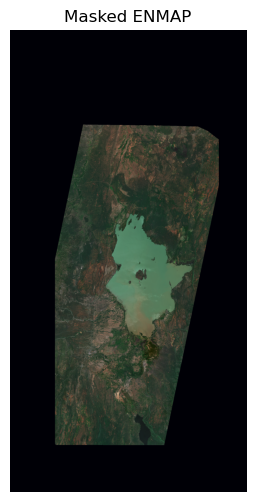

In [9]:
# Path to your masked raster saved from QGIS
masked_raster_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\classification\enmap_20250517_maskedv2.tif"

# Open the raster with rasterio
with rasterio.open(masked_raster_path) as src:
    enmap = src.read()  # reads all bands: shape (bands, height, width)
    profile = src.profile
    nodata = src.nodata

print(f"Raster loaded with {enmap.shape[0]} bands, size: {enmap.shape[1]} x {enmap.shape[2]}")

# visualize RGB (bands 48, 30, 16; zero-indexed: 47, 29, 15)
r, g, b = 47, 29, 15
rgb = np.stack([enmap[r], enmap[g], enmap[b]], axis=2)

# normalization for display
def normalize(band):
    band_min, band_max = band.min(), band.max()
    return (band - band_min) / (band_max - band_min)
rgb_norm = np.dstack([normalize(rgb[:,:,i]) for i in range(3)])

plt.figure(figsize=(8, 6))
plt.imshow(rgb_norm)
plt.title("Masked ENMAP")
plt.axis('off')
plt.show()


c:\Users\Ethel Ogallo\anaconda3\envs\zfl_wetland\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


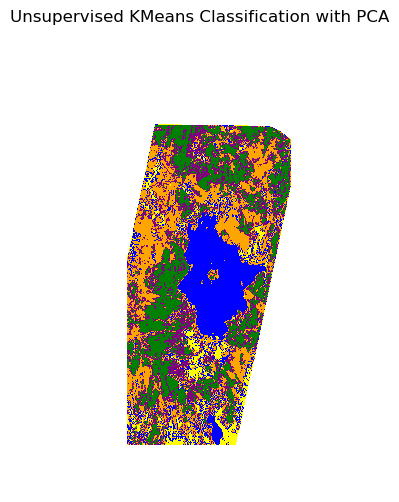

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap


# enmap shape = (bands, height, width)
bands, height, width = enmap.shape

# Reshape to (n_pixels, n_bands)
flat_pixels = enmap.reshape(bands, -1).T  # shape: (height * width, bands)

# Mask out pixels where all band values are zero (NoData)
valid_mask = ~np.all(flat_pixels == 0, axis=1)
clustering_data = flat_pixels[valid_mask]

# sanity check
if clustering_data.shape[0] == 0:
    raise ValueError("No valid pixels found!")

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(clustering_data)


# Dimensionality reduction using PCA
n_components = 20  # number of PCA components to keep
pca = PCA(n_components=n_components, random_state=42)
data_pca = pca.fit_transform(data_scaled)

#  KMeans clustering
n_clusters = 5  # number of clusters 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_pca)


# Assign cluster labels
cluster_labels = np.full(flat_pixels.shape[0], -1, dtype=int)  # -1 for NoData
cluster_labels[valid_mask] = kmeans.labels_

# Reshape to original image shape
classified_img = cluster_labels.reshape(height, width)


# Visualize 
# Add white as first color for NoData, then cluster colors
colors = ['white', 'yellow', 'blue', 'orange', 'purple', 'green'][:n_clusters + 1]
cmap = ListedColormap(colors)

# Shift -1 to 0 (white), cluster labels 0–n to 1–n+1
display_img = classified_img + 1

plt.figure(figsize=(8, 6))
plt.imshow(display_img, cmap=cmap)
plt.title("Unsupervised KMeans Classification with PCA")
plt.axis('off')
plt.show()
